# Pretty Painting with CycleGAN

My introduction to GANs. Trying to recreate the code for image-to-image translation using CycleGAN for monet painting. I'm going to based off from this [Machine Learning Mastery Tutorial](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/).

In [1]:
import tensorflow as tf
import os, json, shutil
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras import Model, losses, optimizers
import glob
from tqdm import tqdm
import random

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
ls "data"

 Volume in drive F is Files Volume
 Volume Serial Number is 301F-B35F

 Directory of f:\git\Pretty-Paintings-With-CycleGan\data

12/30/2021  10:57 PM    <DIR>          .
12/30/2021  10:57 PM    <DIR>          ..
10/17/2020  01:31 PM           535,331 metadata.csv
12/30/2021  10:57 PM    <DIR>          testA
12/30/2021  10:57 PM    <DIR>          testB
12/30/2021  10:57 PM    <DIR>          trainA
12/30/2021  10:57 PM    <DIR>          trainB
               1 File(s)        535,331 bytes
               6 Dir(s)  128,586,522,624 bytes free


## import the data
first time only

In [7]:
DataDir = "F:\git\Pretty-Paintings-With-CycleGan\data"

train_monet = glob.glob("data/trainA/*")
train_photo = glob.glob("data/trainB/*")
test_monet = glob.glob("data/testA/*")
test_photo = glob.glob("data/testB/*")

print(f"train monet length: {len(train_monet)}")
print(f"train photo length: {len(train_photo)}")
print(f"test monet length: {len(test_monet)}")
print(f"test photo length: {len(test_photo)}")

# variables to store the data
# Monet
dataM = []
# Photos
dataP = []

# loading in the images
# for better pratice, should include try catch statement in case the data isn't clean

# I'm going to combine the train and test datasets because it provides more data and 
# the CycleGAN architecture doesn't generate loss based on a validation set, rather it uses another GAN to generate adversarial loss function
for img in tqdm(train_monet, desc="loading train Monet"):
    img_array = np.array(Image.open(img))
    dataM.append(img_array)

for img in tqdm(train_photo, desc="loading train photo"):
    img_array = np.array(Image.open(img))
    dataP.append(img_array)

for img in tqdm(test_monet, desc="loading test monet"):
    img_array = np.array(Image.open(img))
    dataM.append(img_array)

for img in tqdm(test_photo, desc="loading test photo"):
    img_array = np.array(Image.open(img))
    dataP.append(img_array)

# converting them to numpy arrays
dataM = np.array(dataM)
dataP = np.array(dataP)

print(f"Monet data shape: {dataM.shape}")
print(f"Photo data shape: {dataP.shape}")

# Save numpy data in compressed format
filename = 'photo2monet.npz'
np.savez_compressed(filename, dataM, dataP)
print('Saved dataset: ', filename)

train monet length: 1072
train photo length: 6287
test monet length: 121
test photo length: 751


loading test photo: 100%|██████████| 751/751 [00:00<00:00, 758.59it/s]


Monet data shape: (1193, 256, 256, 3)
Photo data shape: (7038, 256, 256, 3)
Saved dataset:  photo2monet.npz


## Load data and verify data

Loaded:  (1193, 256, 256, 3) (7038, 256, 256, 3)


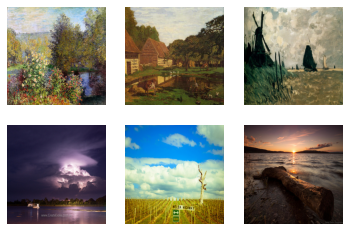

In [3]:
# load and plot the prepared dataset
from numpy import load
# load the dataset
data = load('photo2monet.npz')
dataM, dataP = data['arr_0'], data['arr_1']
print('Loaded: ', dataM.shape, dataP.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataM[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataP[i].astype('uint8'))
plt.show()

## Creating the Model

In [25]:
#import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.models import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow_addons.layers import InstanceNormalization

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model


# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

## Image Preprocessing

In [ ]:
#manipulation methods to prevent overfitting

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image